In [1]:
import numpy as np
from scipy import signal
import matplotlib.pylab as plt
import configparser
import time

import sys
sys.path.append('s4_readout_model/')

from aliased_noise import aliased_noise
from powerlawnoise import powerlaw_psd_gaussian

plt.ion()

do_plot = True

In [53]:
configfile = configparser.ConfigParser()
configfile.read('s4_readout_model/slac_cd36.cfg')

# Number of times to readout full array (all num_rows rows)
num_array_visits = int(1e4)
# Number of samples we're averaging per row visit.
num_downsamples = 10
# ADC sample rate
adc_freq = 1.25e8
# Row length - number of ADC samples per row visit
row_len = 100
# Number of rows we're multiplexing
num_rows = 80
# Input voltage bandwidth
analog_f3db_hz = 1.6e7
# Input voltage white noise level
v_noise = 1e-9 #V/rt(Hz)
# Input voltage 1/f noise level @ 1 Hz
v_1f = 1e4
# Turns ratio
turns_ratio = float(configfile['SQ1']['SQ1_M_IN_PICOHENRY'])/float(configfile['SQ1']['SQ1_M_FB_PICOHENRY'])
# Feedback resistor
SQ1_FB_BACKPLANE_RESISTANCE_OHMS = float(configfile['SQ1']['SQ1_FB_BACKPLANE_RESISTANCE_OHMS'])
#SQ1 Slope
dI_SSAin_dI_SQ1in = float(configfile['SQ1']['dI_SSA_IN_dI_SQ1_IN'])
#SSA Slope
dV_SSA_dI_SSAin = 1/float(configfile['SSA']['dI_SSA_IN_dV_SSA']) #nV per pA
#M_IN SSA
SSA_M_IN_PICOHENRY = float(configfile['SSA']['SSA_M_IN_PICOHENRY'])
#M_IN SSA
SSA_M_FB_PICOHENRY = float(configfile['SSA']['SSA_M_FB_PICOHENRY'])
#M_FB SSA
R_FB_SSA = float(configfile['SSA']['SSA_FB_BACKPLANE_RESISTANCE_OHMS'])
#R_FB SSA        
R_SQ1_Shunt = float(configfile['SQ1']['SQ1_SHUNT_OHM'])
R_SQ1_Dyn = float(configfile['SQ1']['SQ1_R_dyn'])
R_SQ1_RC_BIAS = float(configfile['SQ1']['SQ1B_BC_RESISTANCE_OHM'])
R_TES_Shunt = 4e-4
R_TES_Op = 6e-3
R_BIAS_TES = float(configfile['TES']['TES_BIAS_BC_RESISTANCE_OHM'])
#Johnson noise parameters
kB = 1.38E-23 #SI units
T_cable = 300 #Kelvin
R_cable = 80 #ohm
sample_quotient = 32
f_aa_filter = 6.2e7

Limit voltage noise to achieve 7 pA/rt(Hz) on SQ1FB is 667.306358381503 nV/rt(Hz).
The corner frequency with this noise would have to be 56.79818570617131 Hz.
My guess at the unumultiplexed noise limit to achieve this is 2.8e-08 nV/rt(Hz)
Using that guess we calculate:
Aliased white noise level is 666.4777314125736 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 667.3063583815031 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SQ1FB is 107.6300578034682 pA/rt(Hz).
My guess at the unumultiplexed noise limit to achieve this is 4.4e-12 nV/rt(Hz)
Using that guess we calculate:
Aliased white noise level is 107.13614653368194 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 107.6300578034682 pA/rt(Hz) at 0.1 Hz


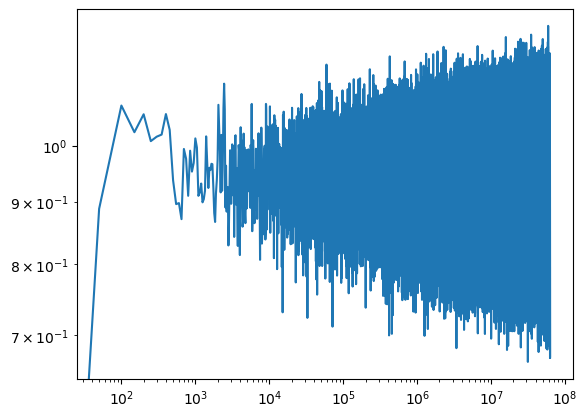

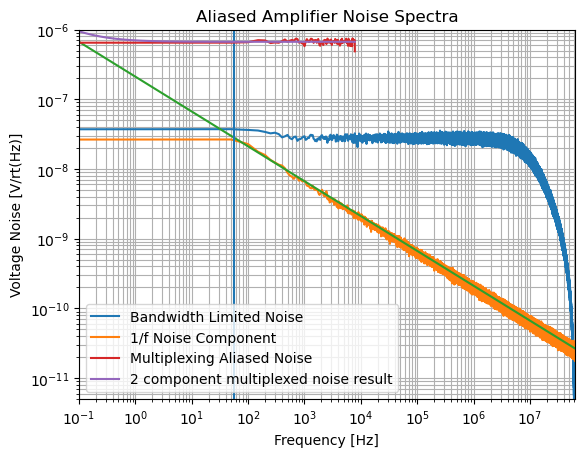

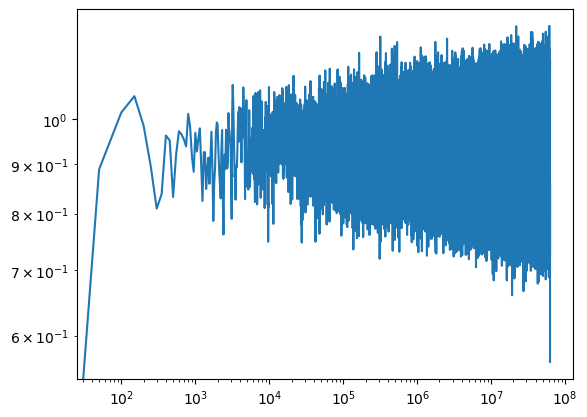

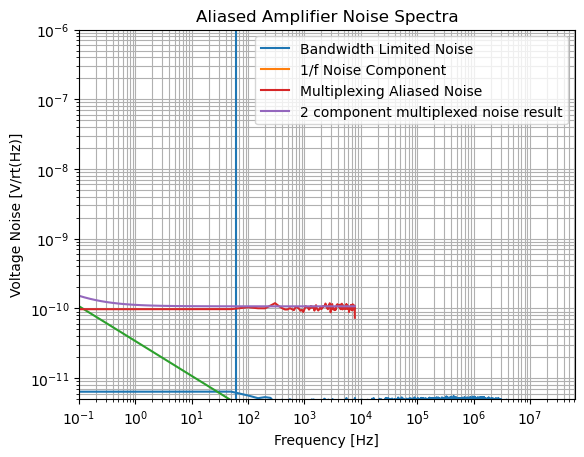

In [15]:
v_max = 7e-3*(SQ1_FB_BACKPLANE_RESISTANCE_OHMS * turns_ratio)
i_max = v_max*1e3/SQ1_FB_BACKPLANE_RESISTANCE_OHMS
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SQ1FB is {v_max} nV/rt(Hz).')
v_limit = 28e-9
f_corner = 0.1* (v_max*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
print(f'My guess at the unumultiplexed noise limit to achieve this is {v_limit} nV/rt(Hz)')
f_bandwidth = 1e7
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Using that guess we calculate:')
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 4.4e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SQ1FB is {i_max} pA/rt(Hz).')
print(f'My guess at the unumultiplexed noise limit to achieve this is {i_limit} nV/rt(Hz)')
print(f'Using that guess we calculate:')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on SQ1B while normal is 959.9625 nV/rt(Hz).
The corner frequency with this noise would have to be 57.59550008789063 Hz.
My guess at the unumultiplexed noise limit to achieve this is 4e-08 nV/rt(Hz)
Using that guess we calculate:
Aliased white noise level is 921.6062999477946 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 959.9625000000001 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SQ1FB is 1279.95 pA/rt(Hz).
My guess at the unumultiplexed noise limit to achieve this is 5.4e-11 nV/rt(Hz)
Using that guess we calculate:
Aliased white noise level is 1297.264334185187 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 1279.95 pA/rt(Hz) at 0.1 Hz


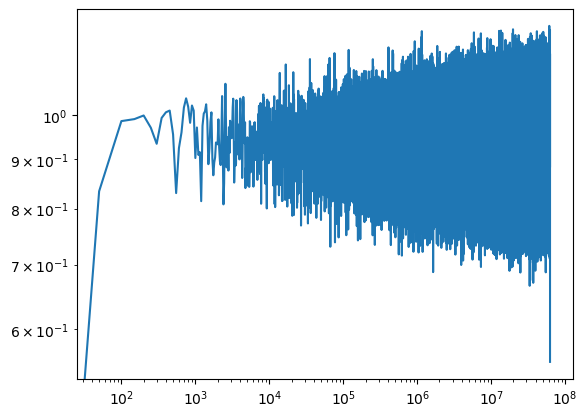

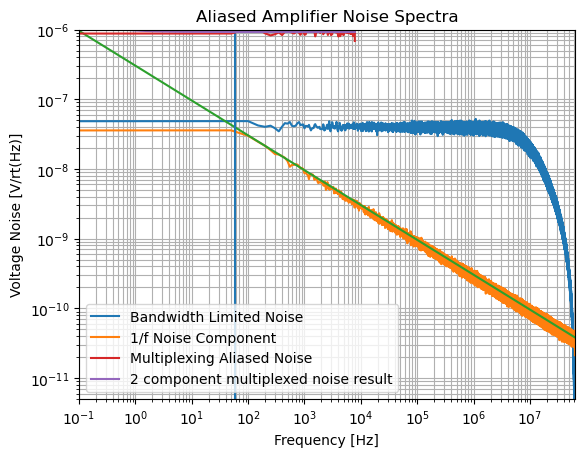

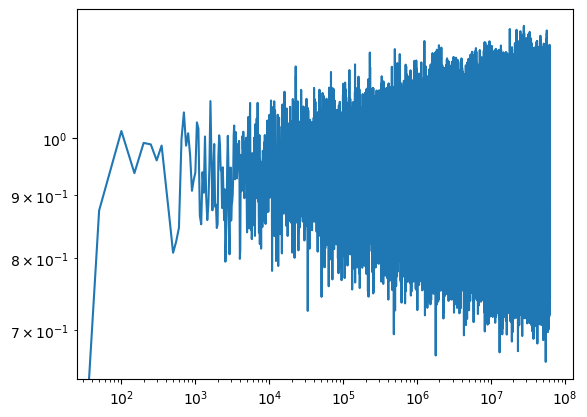

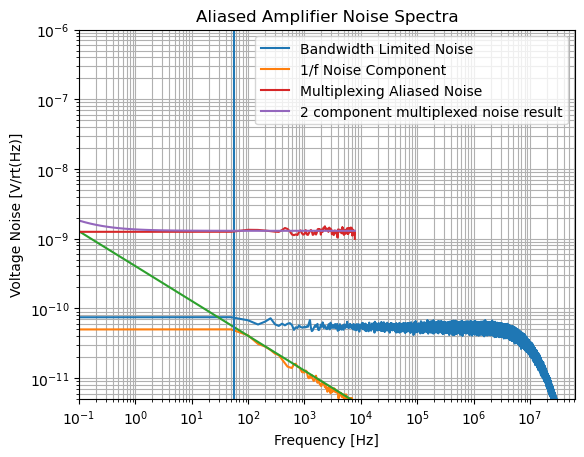

In [23]:
v_max = 7e-3*dI_SSAin_dI_SQ1in * R_SQ1_RC_BIAS * (1 + (R_SQ1_Dyn/R_SQ1_Shunt))
i_max = v_max*1e3/R_SQ1_RC_BIAS
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SQ1B while normal is {v_max} nV/rt(Hz).')
v_limit = 40e-9
f_corner = 0.1* (v_max*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
print(f'My guess at the unumultiplexed noise limit to achieve this is {v_limit} nV/rt(Hz)')
f_bandwidth = 1e7
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Using that guess we calculate:')
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 54e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SQ1FB is {i_max} pA/rt(Hz).')
print(f'My guess at the unumultiplexed noise limit to achieve this is {i_limit} nV/rt(Hz)')
print(f'Using that guess we calculate:')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on SSAFB is 604.4487847222222 nV/rt(Hz).
The corner frequency with this noise would have to be 58.45733333634742 Hz.
Aliased white noise level is 571.7912017460841 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 604.4487847222222 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SSAFB is 120.88975694444443 pA/rt(Hz).
Aliased white noise level is 127.5680510240844 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 120.88975694444441 pA/rt(Hz) at 0.1 Hz


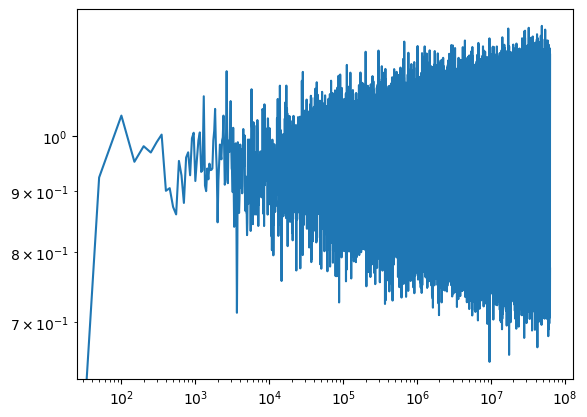

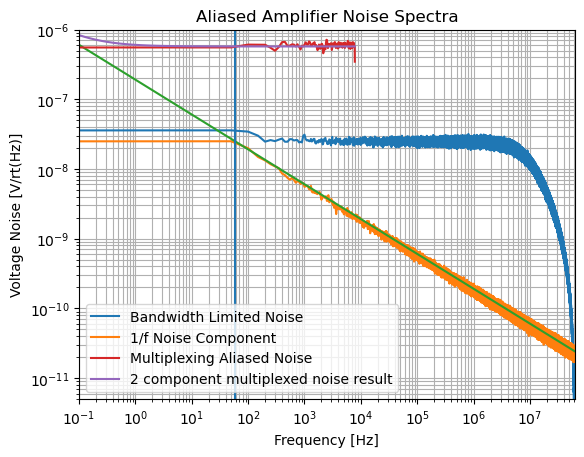

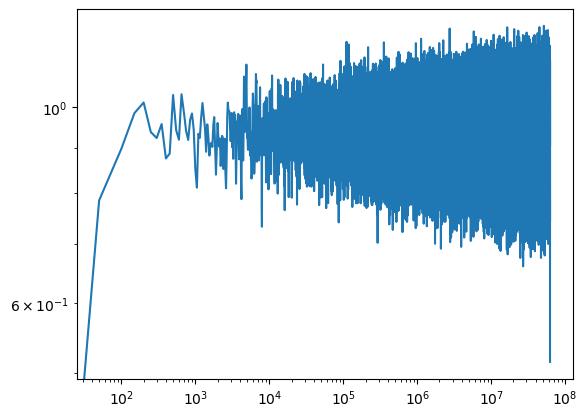

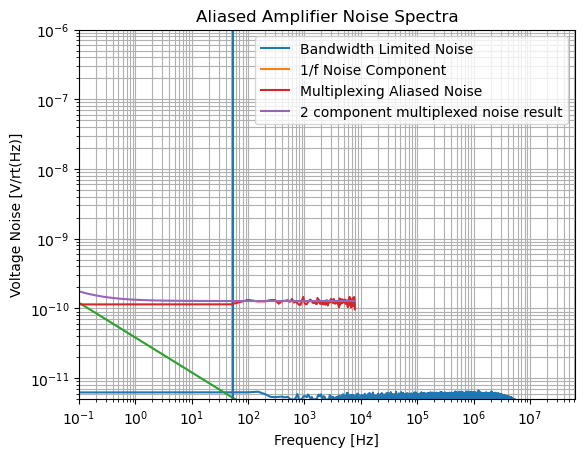

In [28]:
v_max = 7e-3*dI_SSAin_dI_SQ1in * SSA_M_IN_PICOHENRY*R_FB_SSA/SSA_M_FB_PICOHENRY
i_max = v_max*1e3/R_FB_SSA
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SSAFB is {v_max} nV/rt(Hz).')
v_limit = 25e-9
f_corner = 0.1* (v_max*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
f_bandwidth = 1e7
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 5.2e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SSAFB is {i_max} pA/rt(Hz).')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on SSA amplifier is 71.23893805309734 nV/rt(Hz).
The corner frequency with this noise would have to be 60.34466462464974 Hz.
Aliased white noise level is 63.13930146439677 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 71.23893805309737 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SSA Bias and SSA offset is 212.0206489675516 pA/rt(Hz).
Aliased white noise level is 211.5211165358881 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 212.02064896755164 pA/rt(Hz) at 0.1 Hz


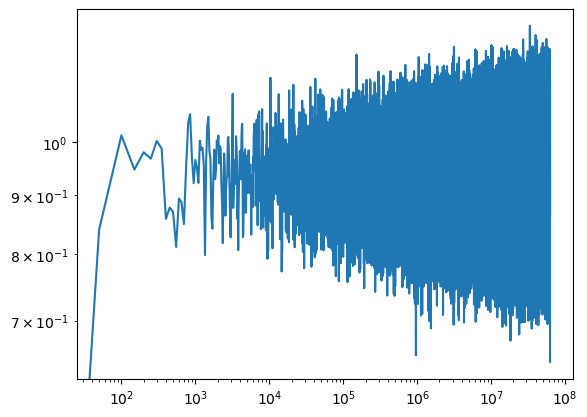

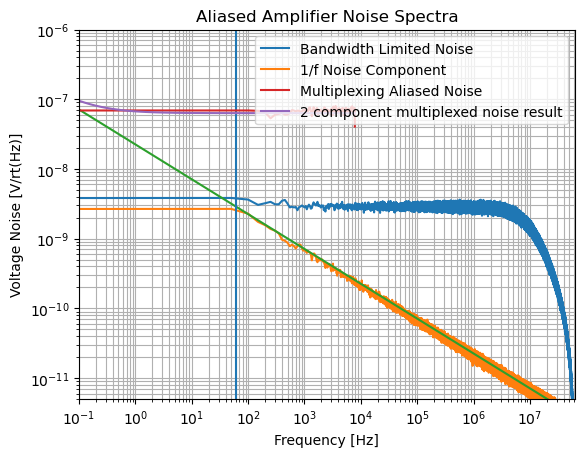

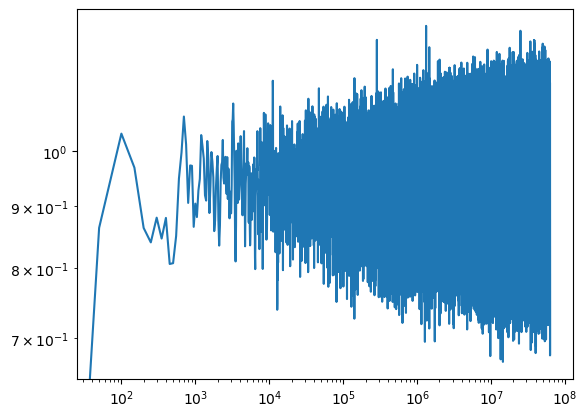

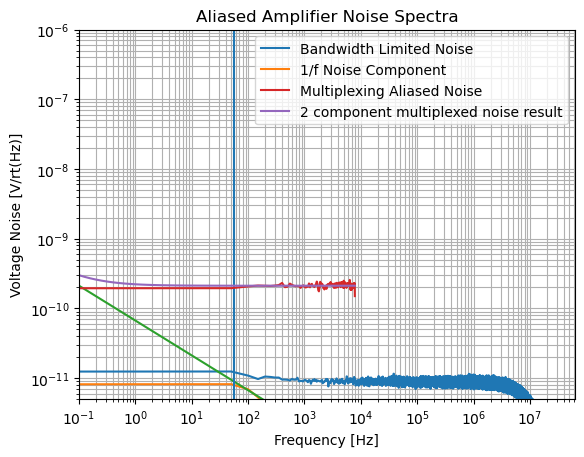

In [38]:
v_max = 7*dI_SSAin_dI_SQ1in * dV_SSA_dI_SSAin
i_max = v_max*1e3/(float(configfile['SSA']['SSA_R_DYN']) + float(configfile['CRYOCABLE']['CRYOCABLE_ROUNDTRIP_RESISTANCE_OHMS']))
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SSA amplifier is {v_max} nV/rt(Hz).')
v_limit = 2.9e-9
f_corner = 0.1* (v_max*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
f_bandwidth = 1e7
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 9e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SSA amplifier is {i_max} pA/rt(Hz).')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on SSA Bias is 3251.5486725663714 nV/rt(Hz).
The corner frequency with this noise would have to be 6.289451975055403 Hz.
Aliased white noise level is 3185.8112569716236 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 3251.5486725663714 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SSA Bias and SSA offset is 212.0206489675516 pA/rt(Hz).
Aliased white noise level is 220.43522288370426 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 212.0206489675516 pA/rt(Hz) at 0.1 Hz


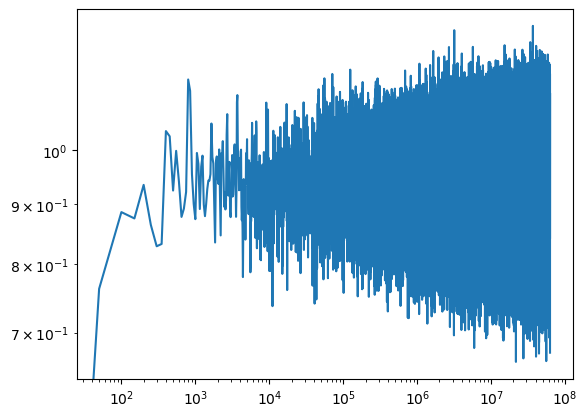

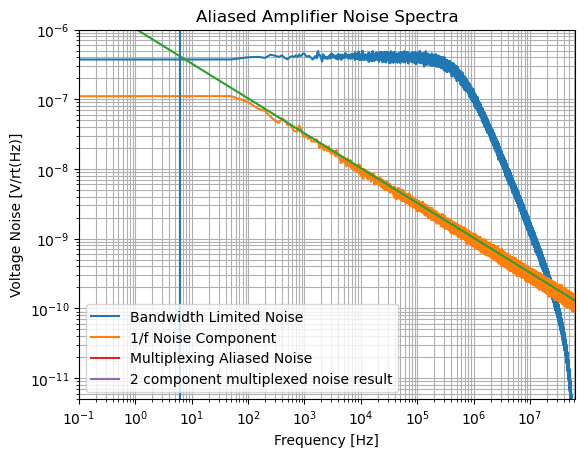

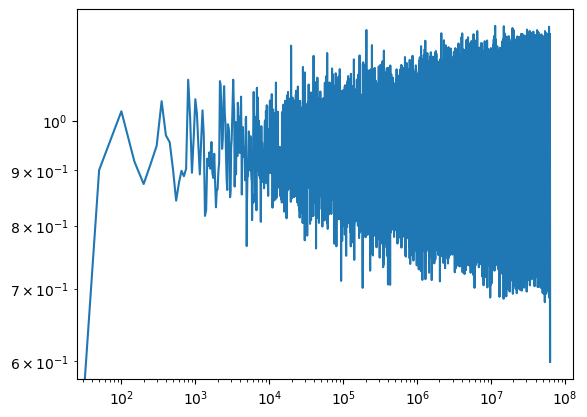

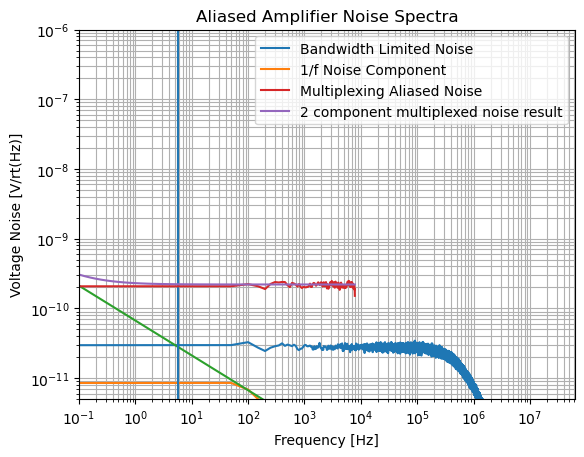

In [45]:
v_max_in = 7*dI_SSAin_dI_SQ1in * dV_SSA_dI_SSAin #voltage noise at input amplifier
R_cold = float(configfile['SSA']['SSA_R_DYN']) + float(configfile['CRYOCABLE']['CRYOCABLE_ROUNDTRIP_RESISTANCE_OHMS'])
R_warm = float(configfile['SSA']['SSA_BIAS_RC_RESISTANCE_OHMS'])
i_max = v_max_in*1e3/(R_cold)
v_max_out = i_max*1e-3*(R_cold + R_warm)
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SSA Bias is {v_max_out} nV/rt(Hz).')
v_limit = 410e-9
f_corner = 0.1* (v_max_out*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
f_bandwidth = 6e5 #Following bandwidth in MCE
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 28e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SSA Bias and SSA offset is {i_max} pA/rt(Hz).')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on SSA Offset is 1830.7548779187546 nV/rt(Hz).
The corner frequency with this noise would have to be 6.335847680573373 Hz.
Aliased white noise level is 1773.7756536102881 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 1830.7548779187546 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on SSA offset is 2145.7511461776307 pA/rt(Hz).
Aliased white noise level is 2100.053239842182 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 2145.7511461776307 pA/rt(Hz) at 0.1 Hz


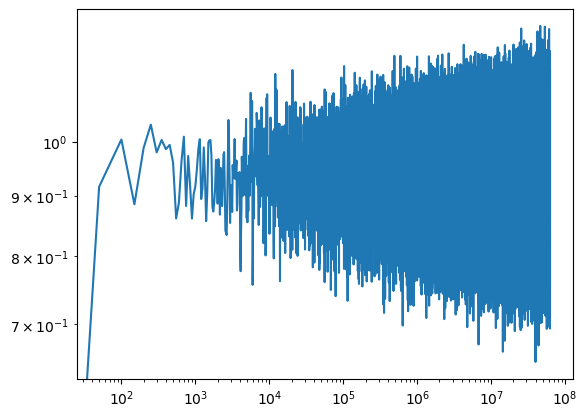

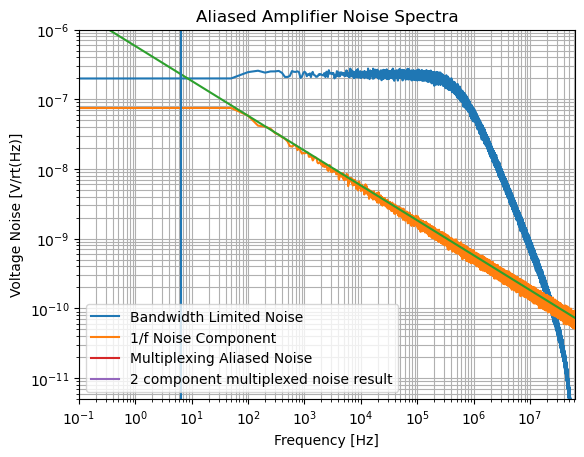

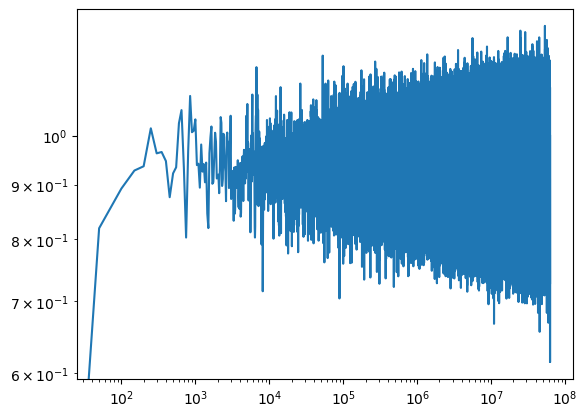

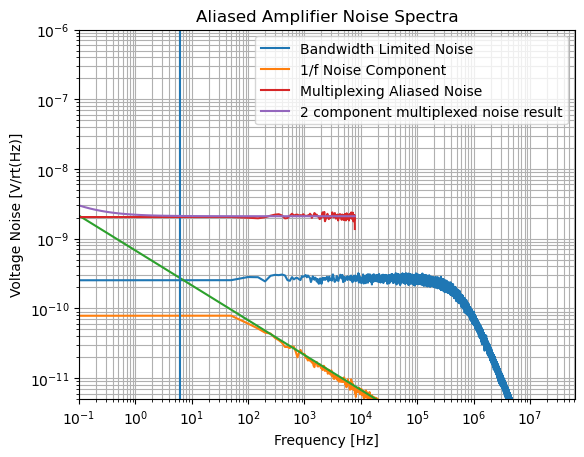

In [50]:
v_max_in = 7*dI_SSAin_dI_SQ1in * dV_SSA_dI_SSAin #voltage noise at input amplifier
i_max = v_max_in*1e3/(float(configfile['PREAMPADC']['SSA_OFFSET_GROUND']))
v_max_out = i_max*1e-3*(float(configfile['PREAMPADC']['SSA_OFFSET_GROUND']) + float(configfile['PREAMPADC']['SA_OFFSET_BIAS_RESISTOR']))
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on SSA Offset is {v_max_out} nV/rt(Hz).')
v_limit = 230e-9
f_corner = 0.1* (v_max_out*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
f_bandwidth = 6e5 #Following bandwidth in MCE
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 270e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on SSA offset is {i_max} pA/rt(Hz).')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')

Limit voltage noise to achieve 7 pA/rt(Hz) on TES Bias is 104.384 nV/rt(Hz).
The corner frequency with this noise would have to be 9.004974757024796 Hz.
Aliased white noise level is 99.94358408275782 nV/rt(Hz) at 400 Hz
Aliased 1/f noise level is 104.384 nV/rt(Hz) at 0.1 Hz

Limit current noise to achieve referred 7 pA/rt(Hz) on TES Bias is 112.0 pA/rt(Hz).
Aliased white noise level is 107.52319024764344 pA/rt(Hz) at 400 Hz
Aliased 1/f noise level is 111.99999999999999 pA/rt(Hz) at 0.1 Hz


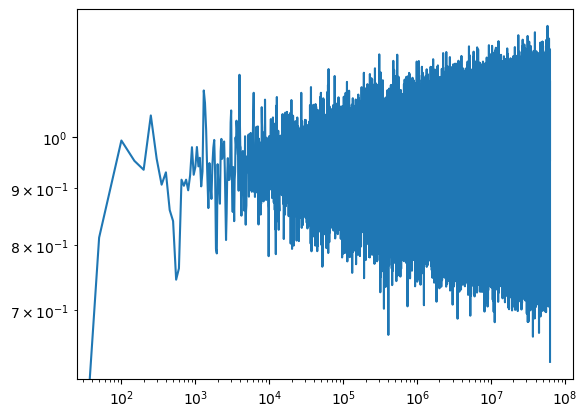

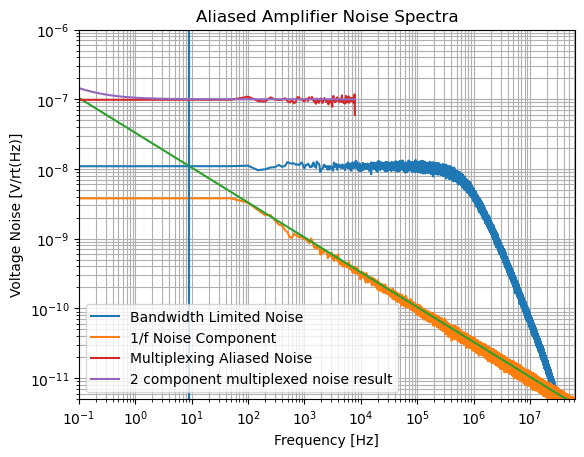

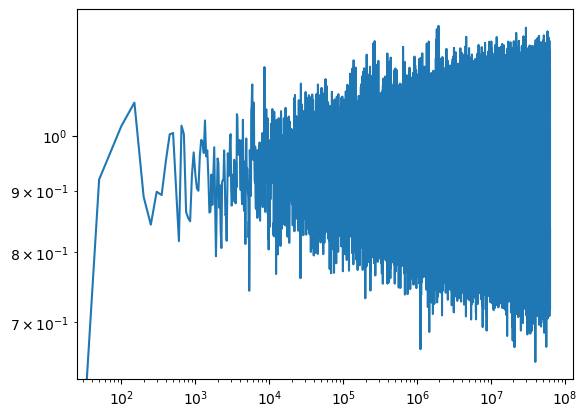

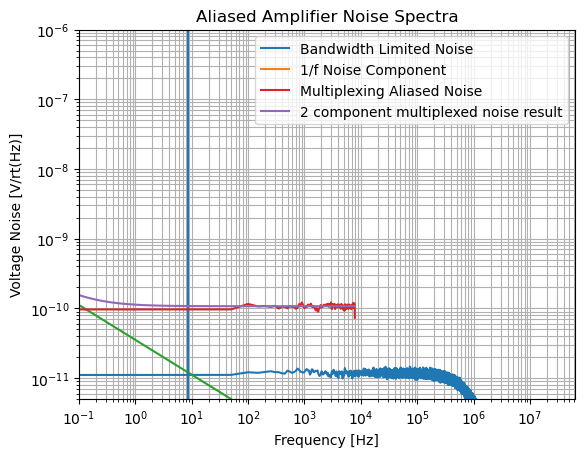

In [58]:
i_max = 7*(1 + R_TES_Op/R_TES_Shunt)
v_max = 2*i_max*R_BIAS_TES*1e-3
print(f'Limit voltage noise to achieve 7 pA/rt(Hz) on TES Bias is {v_max} nV/rt(Hz).')
v_limit = 11e-9
f_corner = 0.1* (v_max*1e-9/v_limit)**2
print(f'The corner frequency with this noise would have to be {f_corner} Hz.')
f_bandwidth = 8e5 
v_aliased, v_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, v_limit, f_corner, sample_quotient, False)
print(f'Aliased white noise level is {v_aliased*1e9} nV/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {v_noise_1f*1e9} nV/rt(Hz) at 0.1 Hz\n')

i_limit = 12e-12
f_corner = 0.1* (i_max*1e-12/i_limit)**2
i_aliased, i_noise_1f, f_filt, v_full, f_downsampled, v_spectrum = aliased_noise(num_array_visits, num_downsamples, adc_freq, row_len, num_rows, f_bandwidth, 1, f_aa_filter, 5, do_plot, i_limit, f_corner, sample_quotient, False)
print(f'Limit current noise to achieve referred 7 pA/rt(Hz) on TES Bias is {i_max} pA/rt(Hz).')
print(f'Aliased white noise level is {i_aliased*1e12} pA/rt(Hz) at 400 Hz')
print(f'Aliased 1/f noise level is {i_noise_1f*1e12} pA/rt(Hz) at 0.1 Hz')